# Framework debugging

**Motivation:** In my *first* two interpolation talks ([talk 1](https://indico.cern.ch/event/933010/contributions/3921789/attachments/2064136/3463628/HHartman_hh4b_Jun_25_2020.pdf), [talk 2](https://indico.cern.ch/event/935460/contributions/3931333/attachments/2068149/3471310/HHartman_hh4b_Jul_2_2020.pdf)), I was seeing *lower* log likelihoods than in the framework that I built to do the trainings more rigorously.

Also - it seemed *problematic* that my MDNs had a higher validation loss than training loss, but that the test loss was *even lower* than the training.
 <img src='figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/mdn_5modes_H_100_vary_lr_withTest.pdf'>

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d
from scipy.stats import norm 

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from eventDisplays import rainbow_text

import torch
from torch import nn
from torch.distributions import Normal, Categorical,OneHotCategorical

from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

**Maybe I'll start off seeing what these distributions look like?**

In [7]:
d = data()

# Add the 2b and deta_hh cuts
mh1_mask = (d.df.m_h1 > 126-45) & (d.df.m_h1 < 126+45)
mh2_mask = (d.df.m_h2 > 116-45) & (d.df.m_h2 < 116+45)
mask = mh1_mask & mh2_mask 

mask = mask & (d.df.abs_deta_hh < 1.5) & (d.df.ntag==2)

d.mlPrepare(mask,['log_m_hh_cor2'])

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5
[ 35842 170938  40596 ... 151090 171841  60724]


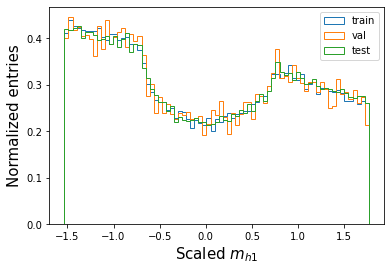

In [4]:
for i, (Xi,l) in enumerate(zip([d.X_tr, d.X_val, d.X_te],['train','val','test'])):
    plt.hist(Xi.numpy()[:,0],75,histtype='step',color=f'C{i}',density=True,label=l)
    
plt.xlabel('Scaled $m_{h1}$',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.legend()
plt.show()

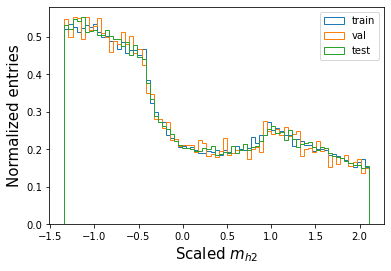

In [5]:
for i, (Xi,l) in enumerate(zip([d.X_tr, d.X_val, d.X_te],['train','val','test'])):
    plt.hist(Xi.numpy()[:,1],75,histtype='step',color=f'C{i}',density=True,label=l)
    
plt.xlabel('Scaled $m_{h2}$',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.legend()
plt.show()

There's an excess in the <span style="color:green">test</span> events a the *lowest* $m_{h2}$ values, so it would be interesting to see if this *matches* with the better likelihood of the test events in the loss curve?

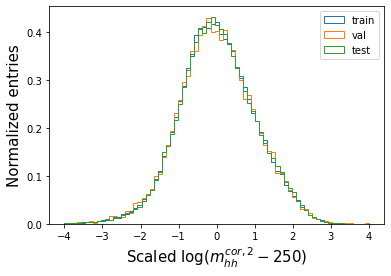

In [6]:
for i, (Yi,l) in enumerate(zip([d.Y_tr, d.Y_val, d.Y_te],['train','val','test'])):
    plt.hist(Yi.numpy(),75,(-4,4),histtype='step',color=f'C{i}',density=True,label=l)
    
plt.xlabel('Scaled $\log (m_{hh}^{cor,2} - 250)$',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.legend()
plt.show()

And - the validation set is possibly seeing a statistical *downward fluctuation* of events close to $m_{hh}^{cor,2}$ of 0 - not sure if this is statistically significant though?

**Next - let's compare massplanes**

In [19]:
K, H  = 5, 100
lr, i = 5e-3, 0

subDir = f'{(d.subDir)}_2b_detaCut/'

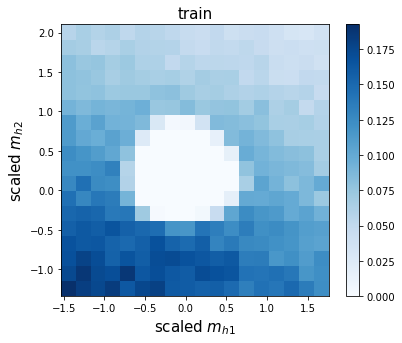

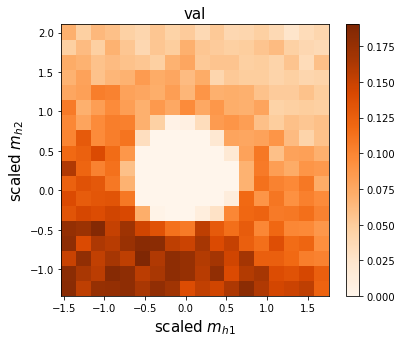

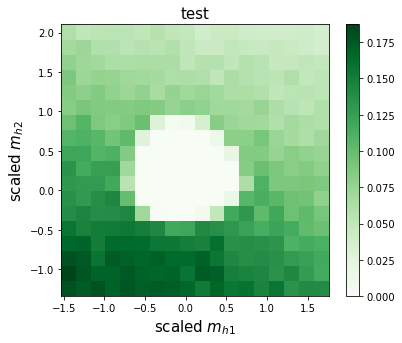

In [13]:
ns = {}

for i, (Xi,l,cmap) in enumerate(zip([d.X_tr, d.X_val, d.X_te],['train','val','test'],
                                    ['Blues','Oranges','Greens'])):
    
    plt.figure(figsize=(6,5))

    ni,e1,e2,_ = plt.hist2d(*Xi.numpy().T,18,cmap=cmap,density=True)
    ns[l] = ni
    
    plt.xlabel('scaled $m_{h1}$',fontsize=15)
    plt.ylabel('scaled $m_{h2}$',fontsize=15)
    
    plt.title(l,fontsize=15)
    plt.colorbar()
    
    plt.savefig(f'figures/{subDir}/mdn_{K}_H_{H}_lr_{lr}_iter0/massplane_{l}.pdf',bbox_inches='tight')
    
plt.show()

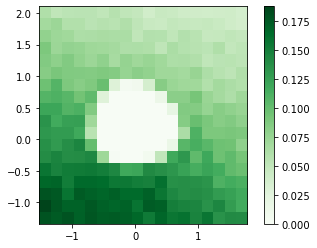

In [14]:
# Quick sanity check!
plt.imshow(ns['test'].T[::-1],extent=[*e1[[0,-1]],*e2[[0,-1]]],cmap='Greens')
plt.colorbar()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


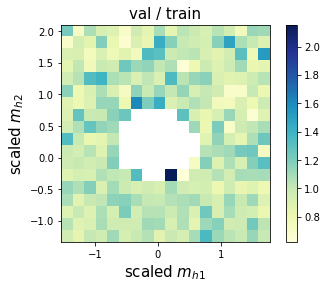

In [15]:
plt.imshow((ns['val'] / ns['train']).T[::-1],extent=[*e1[[0,-1]],*e2[[0,-1]]],cmap='YlGnBu')
plt.colorbar()

plt.xlabel('scaled $m_{h1}$',fontsize=15)
plt.ylabel('scaled $m_{h2}$',fontsize=15)
plt.title('val / train',fontsize=15)

plt.savefig(f'figures/{subDir}/mdn_{K}_H_{H}_lr_{lr}_iter0/massplane_valOvertrain.pdf',bbox_inches='tight')
plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


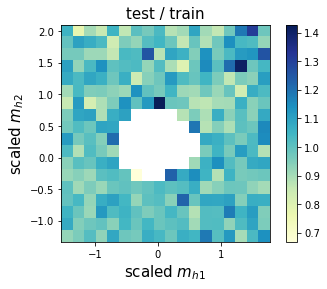

In [16]:
plt.imshow((ns['test'] / ns['train']).T[::-1],extent=[*e1[[0,-1]],*e2[[0,-1]]],cmap='YlGnBu')
plt.colorbar()
plt.xlabel('scaled $m_{h1}$',fontsize=15)
plt.ylabel('scaled $m_{h2}$',fontsize=15)
plt.title('test / train',fontsize=15)
plt.savefig(f'figures/{subDir}/mdn_{K}_H_{H}_lr_{lr}_iter0/massplane_testOvertrain.pdf',bbox_inches='tight')
plt.show()

The MDN in the loss plot that I showed above has *5* modes, so I'll load in the same one here as well.

In [17]:
i

2

In [18]:
mdn = MDN(subDir,lr,0,['log_mhh_cor_2'],i,K,H,load_model=True)
model = mdn.model

lr = 0.005, weight decay = 0, iter = 2, cols = ['log_mhh_cor_2']


In [19]:
model.train()

print('train',mdn.loss(d.X_tr, d.Y_tr).item())

model.eval()
print('val',mdn.loss(d.X_val, d.Y_val).item())
print('test',mdn.loss(d.X_te, d.Y_te).item())


train 1.3986313343048096
val 1.4073253870010376
test 1.3989733457565308


**Notes:** 
- For this MDN, I don't have batch-norm or dropout, so there's no difference between the training and testing modes.
- The fact that my test loss is *so* close to my training loss just means the model is **not overfitting** and the difference between the training and validation sets is due to the random splits! (This is actually pretty encouraging.)


In [20]:
1.4076-1.3987

0.008899999999999908

Ok - so this seems consistent with the plot that I was seeing at the top of the slide, a difference of about .01 in the NLL between the train and val sets - but I'm going to load in the `metrics` just to double check.

In [21]:
filename = f'models/{subDir}/mdn_{K}_H_{H}_lr_{lr}_iter{i}/loss_acc.json'

with open(filename, 'r') as varfile:
    metrics = json.load(varfile)

These models are trained with early stopping on the validation loss

In [22]:
bestEpoch = np.argmin(metrics['val_loss'])
bestEpoch

207

In [23]:
metrics['train_loss'][bestEpoch],metrics['val_loss'][bestEpoch],metrics['test_loss'][bestEpoch]

(1.3986328840255737, 1.4073253870010376, 1.3989733457565308)

Ok - *awesome*, so I *don't* think that this is a bug in my training code rn, it just looks like this is due to the **choice of the train / val / test split**.

In [24]:
keys = ['train','val','test']
nlls = {k:[] for k in keys }

for i in range(5):
    
    # Load in the loss curves
    filename = f'models/{subDir}/mdn_{K}_H_{H}_lr_{lr}_iter{i}/loss_acc.json'
    with open(filename, 'r') as varfile:
        metrics = json.load(varfile)
        
    # Access the loss at the *best* epoch
    bestEpoch = np.argmin(metrics['val_loss'])
    for k in keys:
        nlls[k].append(metrics[f'{k}_loss'][bestEpoch])

In [25]:
nlls[k]

[1.3986666202545166,
 1.3988231420516968,
 1.3989733457565308,
 1.398762583732605,
 1.3990747928619385]

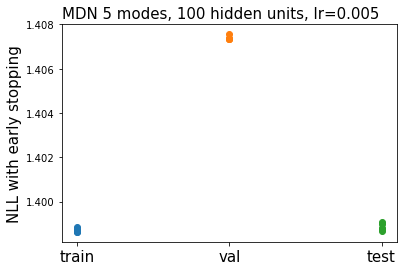

In [26]:
for ki,k in enumerate(keys):
    plt.scatter(ki*np.ones(5),nlls[k],color=f'C{ki}')

ax = plt.gca()
ax.set_xticks(range(3))
ax.set_xticklabels(keys,fontsize=15)
plt.ylabel('NLL with early stopping',fontsize=15)
plt.title(f'MDN {5} modes, {H} hidden units, lr={lr}',loc='left',fontsize=15)
plt.savefig(f'figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/mdn_{K}modes_H_{H}_random_seed_10.pdf',
            bbox_inches='tight')

**Follow-up** 

I still wanted to look at what the log likelihood looked like in the massplane!

In [27]:
logp_tr = -mdn.model.loss(d.X_tr,d.Y_tr).detach()

In [28]:
p_tr = np.exp(logp_tr.numpy())

In [29]:
p_tr

array([0.3957122 , 0.3887338 , 0.3985644 , ..., 0.43509227, 0.3645262 ,
       0.38253164], dtype=float32)

Ok - so I think the easiest thing for me to visualize is the NLL in the massplane.

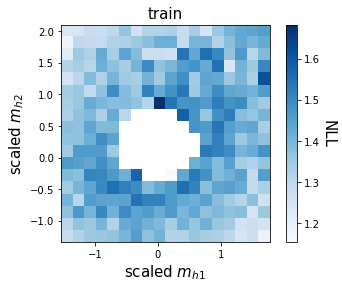

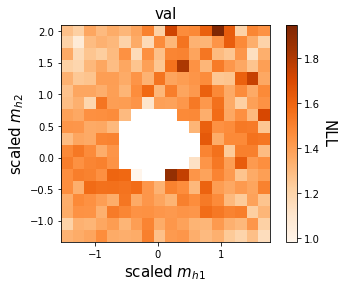

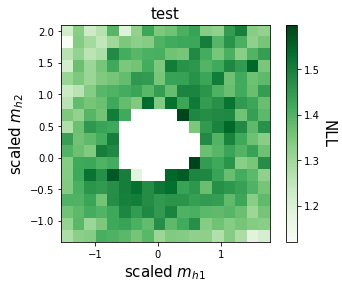

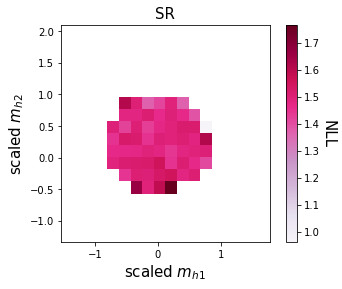

In [33]:
for Xi, Yi, l, cmap in zip([d.X_tr, d.X_val, d.X_te, d.X_SR],[d.Y_tr, d.Y_val, d.Y_te, d.Y_SR],
                           ['train','val','test','SR'], ['Blues','Oranges','Greens','PuRd']):

    nll_tr = mdn.model.loss(Xi,Yi).detach().numpy()

    plt.figure()
    ni,_,_,_ = binned_statistic_2d(Xi[:,0].numpy(),Xi[:,1].numpy(),nll_tr,
                                   bins=18,range=[e1[[0,-1]],e2[[0,-1]]])
    plt.imshow(ni.T[::-1],extent=[*e1[[0,-1]],*e2[[0,-1]]],cmap=cmap)
    plt.xlabel('scaled $m_{h1}$',fontsize=15)
    plt.ylabel('scaled $m_{h2}$',fontsize=15)
    
    plt.title(l,fontsize=15)
    #plt.clabel('NLL')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('NLL',rotation=270,fontsize=15,labelpad=15)
    plt.savefig(f'figures/{subDir}/mdn_{K}_H_{H}_lr_{lr}_iter0/nll_massplane_{l}.pdf',bbox_inches='tight')
    
plt.show()

Ok - so *high* loss is bad, and *low* loss is good - I'm not sure if I can convince myself that this model is getting higher loss close to the unblinded region? Maybe?

It will be interesting to revisit this with the R-NVP models anyways, or to see *how* this plot changes depending on how we modify the training data?

Probably when I revisit this plot to compare across architectures, I'll want to c.f. to the *average* NLL.


**Next test:** 

I was seeing (empirically) that when I was using the wrong SR (and the same random_seed) I was getting a *lower* loss - so I just wanted to take 5 min to verify that this is a reproducible result, and not just the result of a buggy framework.

I'm going to be comparing this to the model that I have in the [July 2nd](https://indico.cern.ch/event/935460/contributions/3931333/attachments/2068149/3471310/HHartman_hh4b_Jul_2_2020.pdf) pres.

In my last talk I said I had 15k events in the training set - so this was just a type-O.

In [65]:
d2 = data()

# The bug is b/c the 2nd term has m_h1 in the denominator instead of m_h2
d2.df['SR_bug'] = (np.sqrt((10*(d2.df.m_h1-120)/d2.df.m_h1)**2+(10*(d2.df.m_h2-110)/d2.df.m_h1)**2) < 1.6)

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


The snippet below will set the relevant datasets in d2.

In [63]:
random_seed=10
cols = ['log_m_hh_cor2','absCosThetaStar']

In [66]:
allCols = ['m_h1','m_h2'] + cols
X = d2.df.loc[mask & (~ d2.df.SR_bug),allCols]

d2.scalar = StandardScaler()
X_norm = d2.scalar.fit_transform(X)

N = X_norm.shape[0]
ix = np.arange(N)

np.random.seed(random_seed)
np.random.shuffle(ix)

N_tr = np.floor(.4*N).astype(int)
N_val = np.floor(.5*N).astype(int)

ix_tr = ix[:N_tr]
ix_val = ix[N_tr:N_val]
ix_te = ix[N_val:]

d2.X_tr = torch.from_numpy(X_norm[ix_tr,:2]).float()
d2.Y_tr = torch.from_numpy(X_norm[ix_tr,2:]).float()

d2.X_val = torch.from_numpy(X_norm[ix_val,:2]).float()
d2.Y_val = torch.from_numpy(X_norm[ix_val,2:]).float()

d2.X_te = torch.from_numpy(X_norm[ix_te,:2]).float()
d2.Y_te = torch.from_numpy(X_norm[ix_te,2:]).float()

# Process SR as well
SR_mask = mask & d2.df.SR_bug
SR_norm  = d2.scalar.transform(d2.df.loc[SR_mask,allCols])

d2.X_SR = torch.from_numpy(SR_norm[:,:2]).float()
d2.Y_SR = torch.from_numpy(SR_norm[:,2:]).float()


If it's harder to estimate the density in the SR maybe including more difficult events *not* in the training set could make the loss easier to fit?

In [69]:
rnvp = RealNVP(d2.subDir, 1e-3, 1e-6, cols, 0, 5, 64,tag='_buggySR',load_model=True)

lr = 0.001, weight decay = 1e-06, iter = 0, cols = ['log_m_hh_cor2', 'absCosThetaStar']
Setting up a R-NVP model with 5 layers, hidden_dim=64
tensor([0., 1.])


In [103]:
rnvp.train(d2)

Epoch   0 | Train loss  2.9664 | Val loss  2.8572
Epoch  10 | Train loss  2.8327 | Val loss  2.8277
Epoch  20 | Train loss  2.8176 | Val loss  2.8094
Epoch  30 | Train loss  2.8068 | Val loss  2.7998
Epoch  40 | Train loss  2.7915 | Val loss  2.7855
Epoch  50 | Train loss  2.7756 | Val loss  2.7712
Epoch  60 | Train loss  2.7574 | Val loss  2.7542
Epoch  70 | Train loss  2.7464 | Val loss  2.7441
Epoch  80 | Train loss  2.7392 | Val loss  2.7390
Epoch  90 | Train loss  2.7338 | Val loss  2.7337
Epoch 100 | Train loss  2.7296 | Val loss  2.7306
Epoch 110 | Train loss  2.7259 | Val loss  2.7266
Epoch 120 | Train loss  2.7222 | Val loss  2.7241
Epoch 130 | Train loss  2.7191 | Val loss  2.7206
Epoch 140 | Train loss  2.7167 | Val loss  2.7190
Epoch 150 | Train loss  2.7147 | Val loss  2.7166
Epoch 160 | Train loss  2.7135 | Val loss  2.7173
Epoch 170 | Train loss  2.7123 | Val loss  2.7160
Epoch 180 | Train loss  2.7111 | Val loss  2.7146
Epoch 190 | Train loss  2.7108 | Val loss  2.7138


Ok - I have *no* idea why the loss isn't getting as low now.

In [70]:
filename = f'{rnvp.modelDir}/loss_acc.json'
if os.path.exists(filename):
    with open(filename, 'r') as varfile:
        metrics = json.load(varfile)


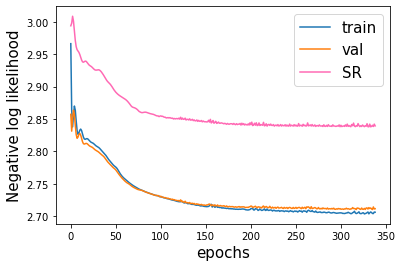

In [71]:
trainingMetric(metrics)

In [73]:
rnvp.loss(d2.X_SR, d2.Y_SR)

tensor(2.8565, grad_fn=<NegBackward>)

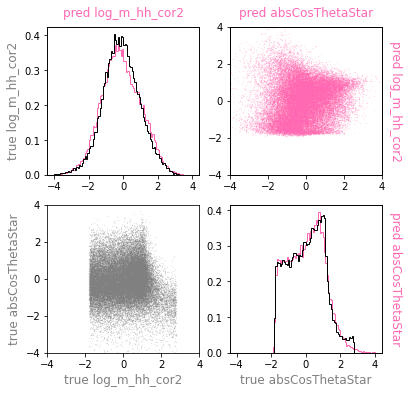

In [74]:
rp = RealNVP_Plots(rnvp, save=False)
rp.plot_correlations(d2.X_SR, d2.Y_SR, 'hotpink', cols)

## Last sanity check study I wanted to do here

Let's compare the MDNs between different train / test splits!

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


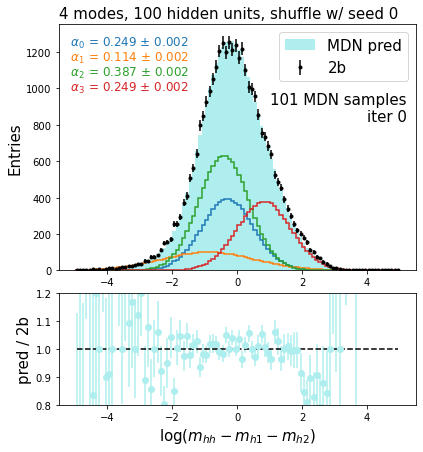

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


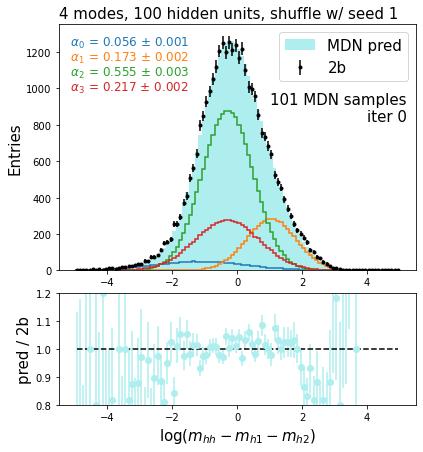

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


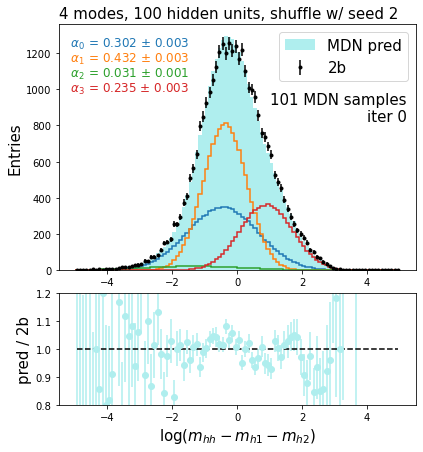

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


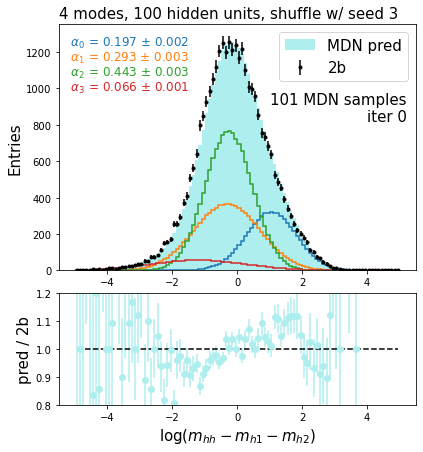

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


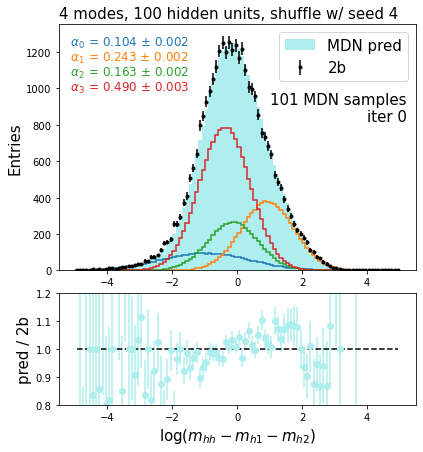

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


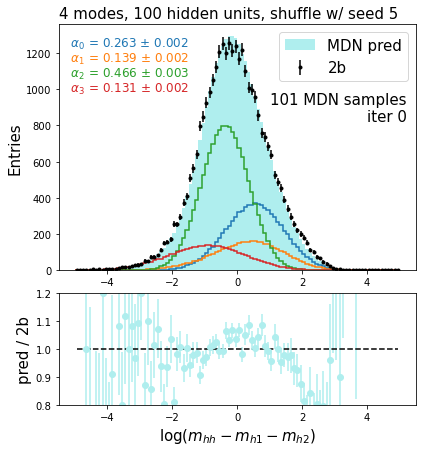

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


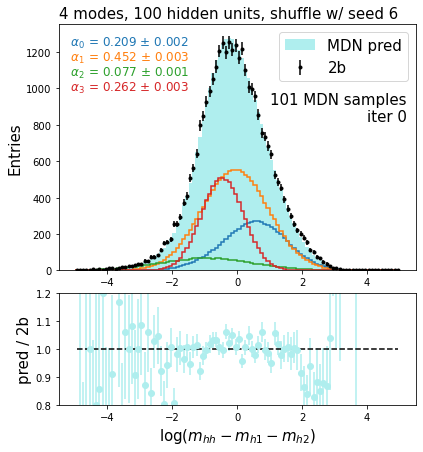

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


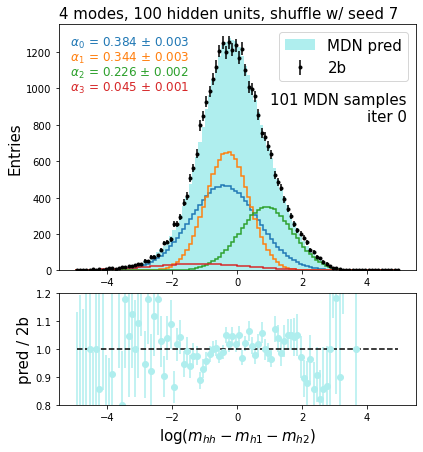

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


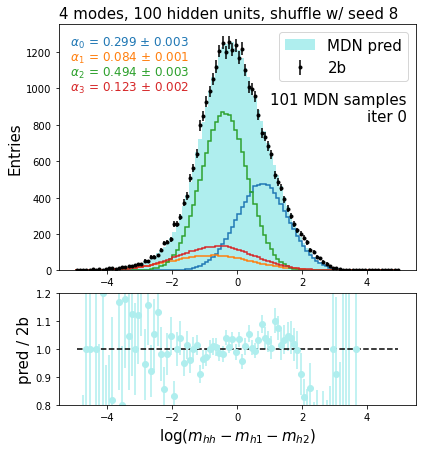

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


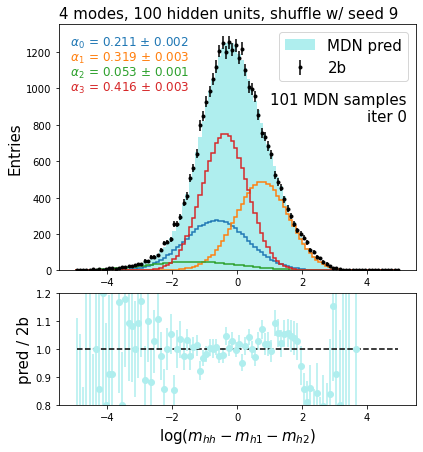

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


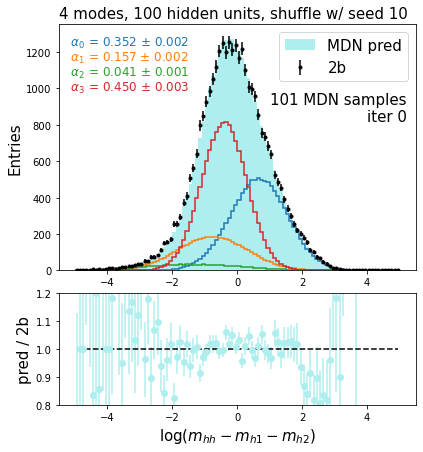

In [59]:
K = 4
mp_k4 = {}

for s in range(11):

    subDir = f'{(d.subDir)}_2b_detaCut'
    if s != 10: subDir += f'_seed{s}'
    
    # Load in the relevant model
    d.mlPrepare(mask, ['log_m_hh_cor2'], random_seed=s)
    
    mdn = MDN(subDir,5e-3,0,['log_mhh_cor_2'],0,K,H,load_model=True)
    mp = MDN_Plots(mdn,save=True)     
    
    X_SR, Y_SR = d.X_SR, d.Y_SR
    title = f'{K} modes, {H} hidden units, shuffle w/ seed {s}'
    mp.samplePrediction(X_SR,Y_SR,title=title,tag=f'_{set}')

    key = f'4modes_seed{s}'
    mp_k4[key] = mp
    

In [44]:
d.subDir

'data_16_PFlow-MAY2019-5jets'

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22

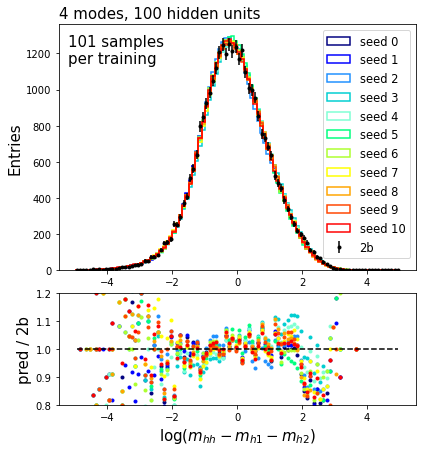

In [50]:
fig = plt.figure(figsize=(6.4, 7))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

e = np.linspace(-5,5,101)
xx = 0.5*(e[:-1]+e[1:])
n_2b, _ = np.histogram(Y_SR.squeeze(),100,(-5,5))

k4_1sample = np.zeros((11,100))

for i,c in enumerate(['navy', 'blue' ,'dodgerblue', 'darkturquoise','aquamarine', 'springgreen', 'greenyellow',
                      'yellow','orange', 'orangered', 'red']):
    
    key = f'4modes_seed{i}'
    
    # Sample 
    wi = mp_k4[key].n_pred
    
    # Plot
    n_pi, _, _ = ax1.hist(xx,100,(-5,5),color=c,label=f'seed {i}',histtype='step',linewidth=1.5,weights=wi)
    ax2.plot(xx,n_pi/n_2b,'.',color=c)
    
    k4_1sample[i] = n_pi
    
# Plot 2b
ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',label='2b')

# Make the plot pretty!
ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=11.5)
ax1.set_title(f'4 modes, {H} hidden units',fontsize=15,loc='left')
ax1.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax1.transAxes)

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.set_xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
ax2.set_ylabel('pred / 2b',fontsize=15)
ax2.set_ylim(.8,1.2)

plt.savefig(f'figures/{subDir}/mdn_4_H_100_lr_0.005_11splits/log_m_hh_cor2_med_SR.pdf',bbox_inches='tight')
plt.show()

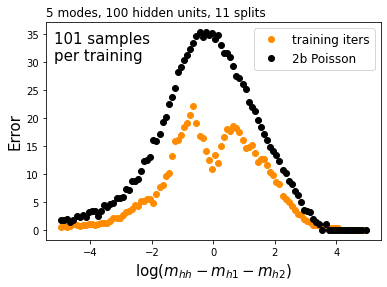

In [56]:
plt.plot(xx,k4_1sample.std(axis=0),'darkorange',marker='o',linewidth=0,label='training iters')
plt.plot(xx,np.sqrt(n_2b),'k',marker='o',linewidth=0,label='2b Poisson')

plt.xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
plt.ylabel('Error',fontsize=15)
plt.title(f'5 modes, {H} hidden units, 11 splits',loc='left',fontsize=12)
plt.legend(fontsize=12)

ax = plt.gca()
ax.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax.transAxes)

plt.savefig(f'figures/{subDir}/mdn_4_H_100_lr_0.005_11splits/compareErrs.pdf',bbox_inches='tight')
plt.show()

**And how for 5 modes**

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


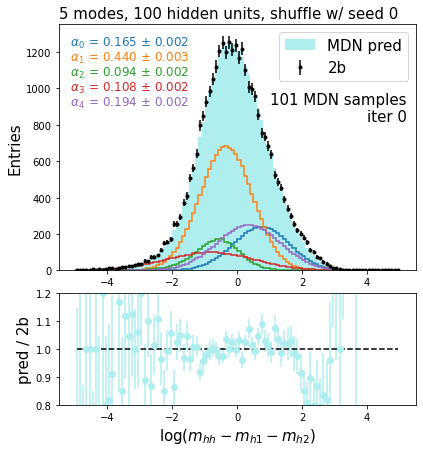

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


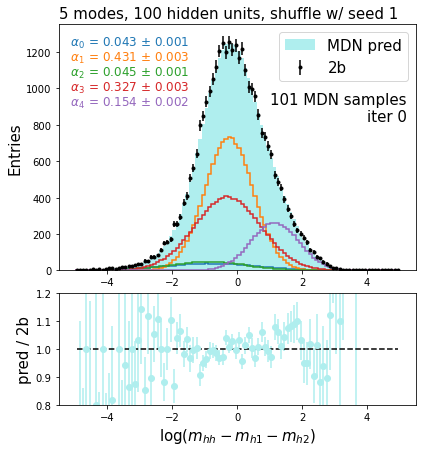

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


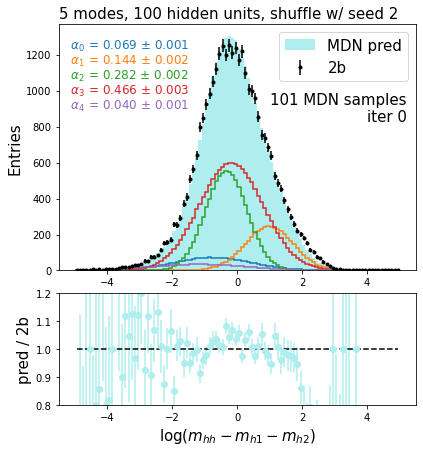

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


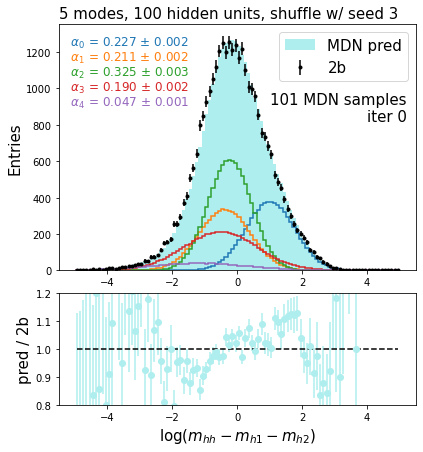

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


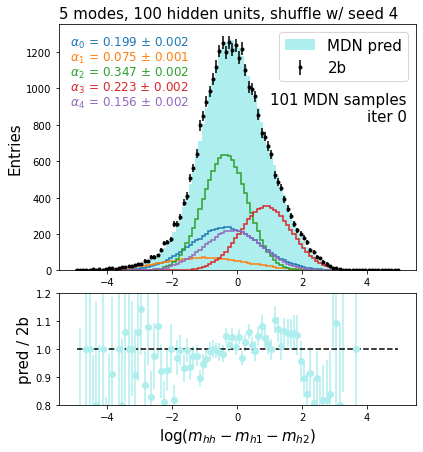

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


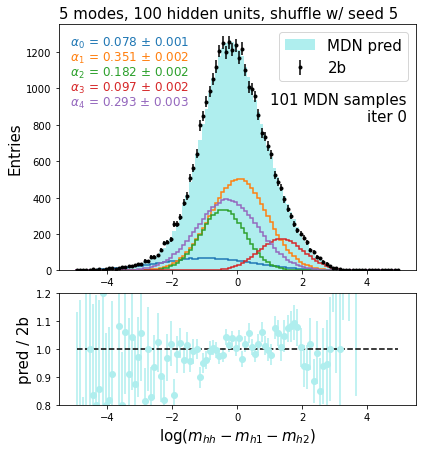

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


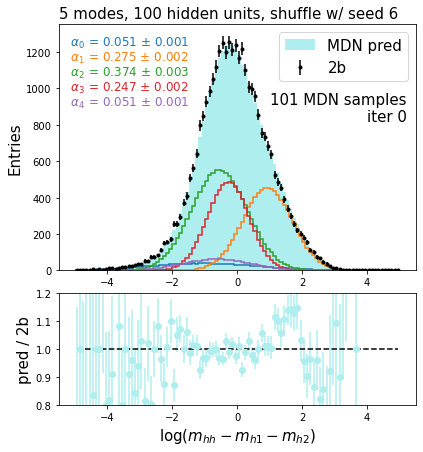

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


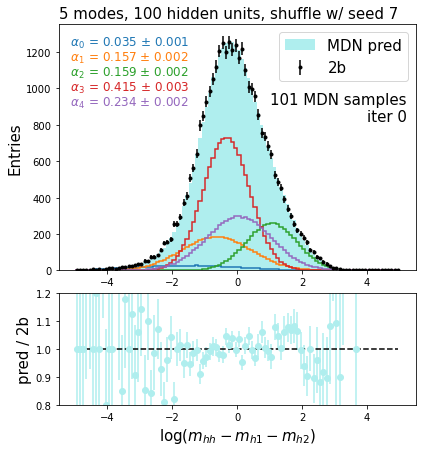

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


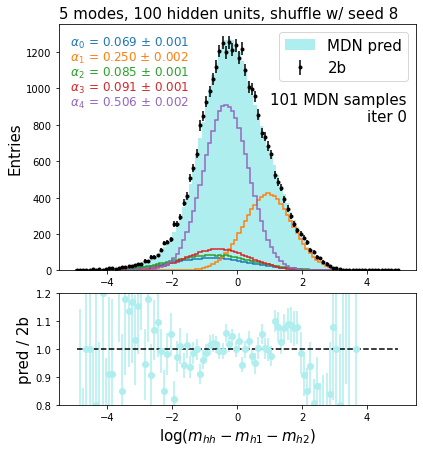

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


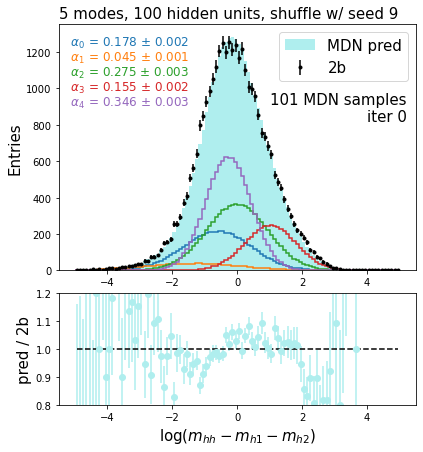

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor_2']


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:155: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


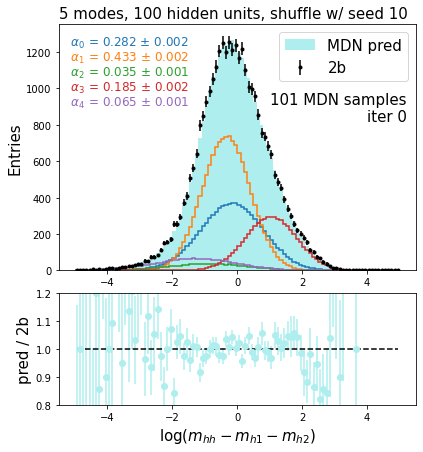

In [60]:
K = 5
mp_k5 = {}

for s in range(11):
    
    subDir = f'{(d.subDir)}_2b_detaCut'
    if s != 10: subDir += f'_seed{s}'
    
    # Load in the relevant model
    d.mlPrepare(mask, ['log_m_hh_cor2'], random_seed=s)
    
    mdn = MDN(subDir,5e-3,0,['log_mhh_cor_2'],0,K,H,load_model=True)
    mp = MDN_Plots(mdn,save=True)    
    
    X_SR, Y_SR = d.X_SR, d.Y_SR
    title = f'{K} modes, {H} hidden units, shuffle w/ seed {s}'
    mp.samplePrediction(X_SR,Y_SR,title=title,tag=f'_{set}')
    
    key = f'5modes_seed{s}'
    mp_k5[key] = mp
    

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22

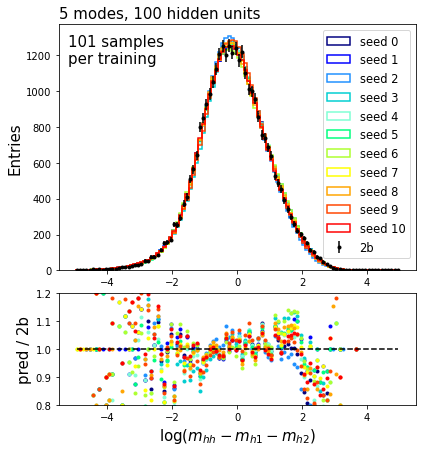

In [49]:
fig = plt.figure(figsize=(6.4, 7))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

e = np.linspace(-5,5,101)
xx = 0.5*(e[:-1]+e[1:])
n_2b, _ = np.histogram(Y_SR.squeeze(),100,(-5,5))

k5_1sample = np.zeros((11,100))

for i,c in enumerate(['navy', 'blue' ,'dodgerblue', 'darkturquoise','aquamarine', 'springgreen', 'greenyellow',
                      'yellow','orange', 'orangered', 'red']):
    
    key = f'5modes_seed{i}'
    
    # Sample 
    wi = mp_k5[key].n_pred
    
    # Plot
    n_pi, _, _ = ax1.hist(xx,100,(-5,5),color=c,label=f'seed {i}',histtype='step',linewidth=1.5,weights=wi)
    ax2.plot(xx,n_pi/n_2b,'.',color=c)
    
    k5_1sample[i] = n_pi
    
# Plot 2b
ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',label='2b')

# Make the plot pretty!
ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=11.5)
ax1.set_title(f'5 modes, {H} hidden units',fontsize=15,loc='left')
ax1.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax1.transAxes)

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.set_xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
ax2.set_ylabel('pred / 2b',fontsize=15)
ax2.set_ylim(.8,1.2)

plt.savefig(f'figures/{subDir}/mdn_5_H_100_lr_0.005_11splits/log_m_hh_cor2_med_SR.pdf',bbox_inches='tight')
plt.show()

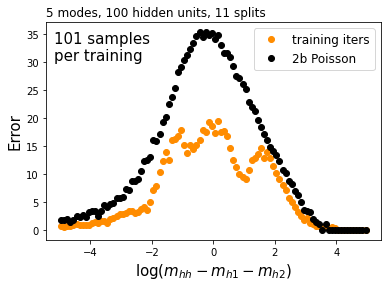

In [55]:
plt.plot(xx,k5_1sample.std(axis=0),'darkorange',marker='o',linewidth=0,label='training iters')
plt.plot(xx,np.sqrt(n_2b),'k',marker='o',linewidth=0,label='2b Poisson')

plt.xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
plt.ylabel('Error',fontsize=15)
plt.title(f'5 modes, {H} hidden units, 11 splits',loc='left',fontsize=12)
plt.legend(fontsize=12)

ax = plt.gca()
ax.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax.transAxes)

plt.savefig(f'figures/{subDir}/mdn_5_H_100_lr_0.005_11splits/compareErrs.pdf',bbox_inches='tight')
plt.show()